# ===Cross-validation===

Here we consider a class of methods that estimate the test error (the average error that results from using a statistical learning method to predict the response on a new observation) by holding out a subset of the training observations from the fitting process, and then applying the statistical learning method to those held out observations.

# Get the data

We use the [dataset _auto_](https://archive.ics.uci.edu/ml/datasets/auto+mpg) from the UCI Machine Learning Repository.  

Specifically, we will use the feature _horsepower_ (i.e., the car's HP number) to predict its fuel consumption (the _mpg_ feature).

In [1]:
import pandas as pd

In [2]:
autoData = pd.read_csv('../datasets/Auto.csv', na_values='?') 

In [3]:
autoData.shape

(397, 9)

397 examples of 9 features

In [4]:
autoData.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'name'],
      dtype='object')

We are interested in the _mpg_ and the _horsepower_ features.

In [5]:
autoData.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [6]:
autoData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
mpg             397 non-null float64
cylinders       397 non-null int64
displacement    397 non-null float64
horsepower      392 non-null float64
weight          397 non-null int64
acceleration    397 non-null float64
year            397 non-null int64
origin          397 non-null int64
name            397 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 28.0+ KB


In [7]:
autoData.isnull().values.any()

True

There are NaNs. We remove those observations before proceeding.

In [8]:
autoData[autoData.isnull().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,2,renault 18i


In [9]:
autoData.dropna(axis=0, inplace=True) # Drop any row that has NaNs within it

In [10]:
autoData[autoData.isnull().any(axis=1)]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name


In [11]:
  # horsepower feature is our input X
X = autoData[['horsepower']]
X.shape

(392, 1)

In [12]:
X.describe()

,horsepower
count,392.000000
mean,104.469388
std,38.491160
min,46.000000
25%,75.000000
50%,93.500000
75%,126.000000
max,230.000000


In [13]:
m = X.shape[0]  # number of examples
m

392

In [14]:
  # mpg is our output Y, what we want to predict
Y = autoData.mpg.copy() # copy “y” column values out
len(Y)

392

## Visualise the data

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

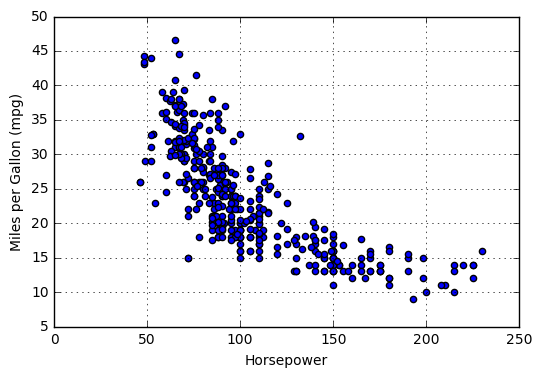

In [16]:
fig = plt.scatter(X, Y)
fig = plt.grid(True)
fig = plt.xlabel('Horsepower')
fig = plt.ylabel('Miles per Gallon (mpg)')

# Fit a linear regression model

In [17]:
from sklearn import linear_model

In [18]:
#
# : Create the linear regression model 
#
model = linear_model.LinearRegression()

In [19]:
model.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

These are the model's coefficients:

In [20]:
model.intercept_

39.93586102117046

In [21]:
model.coef_

array([-0.15784473])

The model would look like $mpg = 39.9 - 0.15 * horsepower$.  
Let's display the linear regression line in the previous chart:

In [22]:
y_plot = model.predict([[40],[230]])
y_plot

array([ 33.62207169,   3.63157235])

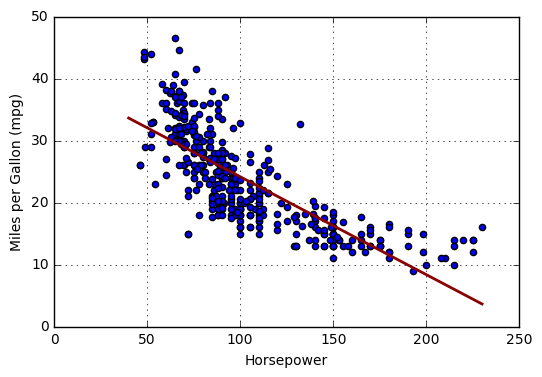

In [23]:
fig = plt.scatter(X, Y)
fig = plt.grid(True)
fig = plt.xlabel('Horsepower')
fig = plt.ylabel('Miles per Gallon (mpg)')
fig = plt.plot([40,230], y_plot, '-', color='darkred', linewidth=2)

We can already see that a simple linear regression model will not be very accurate ... probably a curve would better approximate the real fuel consumption better than a line.  
Let's measure the accuracy using the test-set hold-out approach.

# Test-set approach

Here we randomly divide the available set of observations into two parts: a training set and a test or hold-out set (20% of the entire dataset).  

In scikit-learn a random split into training and test sets can be quickly computed with the _train_test_split_ helper function.

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

## Measure the accuracy of the model

We fit the model on the train dataset:

In [26]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

And measure the accuracy on the test dataset.  
Note: the *score()* function is a shortcut to run *predict()* and then calculate the accuracy.

In [27]:
print('Test Accuracy: {:.3f}'.format(model.score(x_test, y_test)))

Test Accuracy: 0.587


The validation estimate of the test error can be highly variable, depending on precisely which observations are included in the training set and which observations are included in the test set. Every time you split the data into different train/test datasets you get different models and scores. You can try it yourself by removing the fixed random seed above.

# Cross-validation approach

A solution to this problem is a procedure called cross-validation (CV for short).  

## K-Fold 

In the basic approach, called _K-fold CV_, the training set is split into _K_ smaller sets.  
We leave out part _k_, fit the model to the other _K-1_ parts (combined), and then obtain predictions for the left-out k-th part.
This is done in turn for each part _k = 1,2,...K_, and then the results are combined.

In [28]:
from sklearn.model_selection import KFold
import numpy as np

KFold divides all the samples in _K_ groups of samples, called folds, of equal sizes (if possible).

In [29]:
kf = KFold(n_splits = 10).split(X, Y)


Note: I use .iloc to index the Pandas dataframe to avoid that some data become NaN after the split and get this error:  
_ValueError: Input contains NaN, infinity or a value too large for dtype('float64')_.

In [30]:
scores = []
for k, (train_index, test_index) in enumerate(kf):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    model.fit(X_train, Y_train)
    scoreK = model.score(X_train, Y_train)
    scores.append(scoreK)

    print('Fold: {:2d}, Acc: {:.3f}'.format(k+1, scoreK))

print('\nCV accuracy: {:.3f} +/- {:.3f}'.format(np.mean(scores), 
                                                np.std(scores)))

Fold:  1, Acc: 0.608
Fold:  2, Acc: 0.595
Fold:  3, Acc: 0.608
Fold:  4, Acc: 0.613
Fold:  5, Acc: 0.614
Fold:  6, Acc: 0.604
Fold:  7, Acc: 0.605
Fold:  8, Acc: 0.602
Fold:  9, Acc: 0.610
Fold: 10, Acc: 0.610

CV accuracy: 0.607 +/- 0.005


## Leave One Out (LOO) cross-validation

LOO is a special case of the Kfold splitting approach: if _K_ = _n_, this is equivalent to the Leave One Out strategy.

In [31]:
from sklearn.model_selection import LeaveOneOut 

In [32]:
LOO = LeaveOneOut().split(X, Y)

Note: not printing each fold here because LOO is computationally more expensive.

In [33]:
scores = []
for k, (train_index, test_index) in enumerate(LOO):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    model.fit(X_train, Y_train)
    scoreK = model.score(X_train, Y_train)
    scores.append(scoreK)

print('\nCV accuracy: {:.3f} +/- {:.3f}'.format(np.mean(scores), 
                                                np.std(scores)))


CV accuracy: 0.606 +/- 0.001


Now the accuracy of 0.606 is a much more reliable measure than the one from the test-set approach, which could change depending on which test set has been randomly selected.

## A generic cross-validation score evaluating function.

The _sklearn_ helper _cross_val_score_ can quickly estimate the score of a model, using one CV approach, therefore substituting the above code with a more compact form:

In [34]:
from sklearn.model_selection import cross_val_score

In [35]:
# We are passing the entirety of X and y, not X_train or y_train
scores = cross_val_score(model, X, Y, cv=KFold(n_splits=5, shuffle=True,
                                              random_state=1))
print ("Cross-validated scores:", scores)
print('CV accuracy: {:.3f}  +/- {:.3f} '.format (np.mean(scores), np.std(scores)))

Cross-validated scores: [ 0.58656677  0.65131449  0.56557775  0.54515335  0.66048729]
CV accuracy: 0.602  +/- 0.046 


In the first iteration, the accuracy is 58%, in the second iteration the accuracy is 65% and so on.  

Generally a 10-folds is a good compromise between speed and accuracy.

# A model with polynomial features

Now we try to improve our simple model's accuracy by adding polynomial terms to our feature, i.e. transforming it into its power. 

In [36]:
from sklearn.preprocessing import PolynomialFeatures

In [37]:
poly = PolynomialFeatures(degree=2) # quadratic function

In [38]:
  # we first transform our data
x_train2 = poly.fit_transform(x_train)
x_test2  = poly.fit_transform(x_test)

In [39]:
x_train2[0:5]

array([[  1.00000000e+00,   8.40000000e+01,   7.05600000e+03],
       [  1.00000000e+00,   1.10000000e+02,   1.21000000e+04],
       [  1.00000000e+00,   8.30000000e+01,   6.88900000e+03],
       [  1.00000000e+00,   6.50000000e+01,   4.22500000e+03],
       [  1.00000000e+00,   7.40000000e+01,   5.47600000e+03]])

Then we fit a new model to the transformed data:

In [40]:
model2 = linear_model.LinearRegression()
model2.fit(x_train2, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
model2.score(x_test2, y_test)

0.69134645952506046

It looks better, so we can try with a cubic function:

In [42]:
poly = PolynomialFeatures(degree=3) # cubic function
x_train3 = poly.fit_transform(x_train) # again, transform the data
x_test3  = poly.fit_transform(x_test)

In [43]:
model3 = linear_model.LinearRegression()
model3.fit(x_train3, y_train) # fit a new model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
model3.score(x_test3, y_test)

0.69099400625639762

These results show that a model which predicts _mpg_ using a quadratic function of _horsepower_ performs better than a model that involves only a linear function of _horsepower_, and there is little evidence in favour of a model that uses a cubic function of _horsepower_.

# Using the CV approach to tune parameters (model selection)

We can repeat this procedure for increasingly complex polynomial fits. 
This is called model selection.  

To automate the process, we use a _for()_  loop, which iteratively fits polynomial regressions for polynomials of order i = 1 to i = 15, computes the associated cross-validation score and stores it. 

In [45]:
# search for an optimal value of poly n for LR

  # range of n we want to try
n_range = range(1, 15)
  # empty list to store scores
n_scores = []

model_n = linear_model.LinearRegression()

  # 1. we will loop through values of n
for n in n_range:
      # 2. transform features with n degree
    poly = PolynomialFeatures(degree=n)
    x_val_n = poly.fit_transform(X)    

      # 3. obtain cross_val_score for model_n
    scores = cross_val_score(model_n, x_val_n, Y, cv=KFold(n_splits=5, 
                                                           shuffle=True,
                                                           random_state=1)) 
    # 4. append mean of scores to n_scores list
    n_scores.append(scores.mean())

    #print ("Cross-validated scores:", scores)

print('CV accuracy: {:.3f} +/- {:.3f} '.format(np.mean(n_scores), np.std(n_scores)))

CV accuracy: 0.641 +/- 0.075 


In [46]:
# in essence, this is basically running the k-fold cross-validation method n times :
print('Length of list', len(n_scores))
print('Max of list', max(n_scores))

Length of list 14
Max of list 0.687040033801


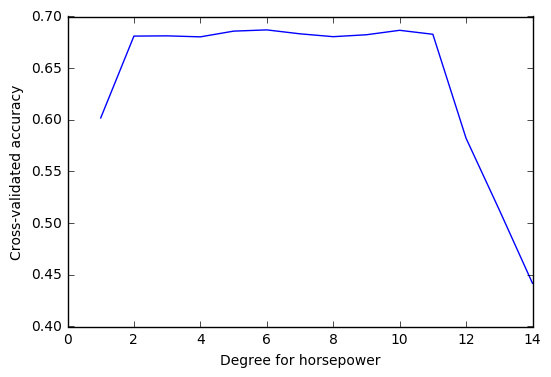

In [47]:
# plot how accuracy changes as we vary the polynomial degree

plt.plot(n_range, n_scores)
plt.xlabel('Degree for horsepower')
plt.ylabel('Cross-validated accuracy')

This is quite typical shape of the curve when examining the model complexity and accuracy, first increasing then reaching the maximum CV accuracy (in this case, it occurs from degree=2 to 12 and then quickly decreasing (overfit).  
This is an example of bias-variance trade off.

We see a sharp improvement in the estimated accuracy between the linear and quadratic fits, but then no clear improvement from using higher-order polynomials.  
**Therefore, the best model is the one with the quadratic function.**